In [1]:
!pip install mediapipe==0.10.14

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.7/35.7 MB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 10.1 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.5
    Uninstalling protobuf-5.29.5:
      Successfully uninstalled protobuf-5.29.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydf 0.13.0 requires protobuf<7.0.0,>=5.29.1, but you have protobuf 4.25.8 which is incompatible.
opentelemetry-proto 1.37.0 requires protobuf<7.0,>=5.0, but you have protobuf 4.25.8 which is incompatible.
grpcio-status 1.71.2 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 4.25.8 which is incompatible.


In [2]:
import mediapipe as mp
print(mp.__version__)


0.10.14


In [3]:
import cv2
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import os

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

Uzyskiwanie danych:

In [5]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [6]:
data_dir = "/content/drive/MyDrive/images"
os.listdir(data_dir)


['serve', 'backhand', 'ready_position', 'forehand']

Inicjalizacja mediapipe

In [7]:
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(
    static_image_mode=False,
    model_complexity=1,
    enable_segmentation=False,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5
)

In [8]:
SELECT_LANDMARKS = [
    11, 12,  # barki
    13, 14,  # łokcie
    15, 16,  # nadgarstki
    23, 24,  # biodra
    25, 26,  # kolana
    27, 28   # kostki
]

funkcja ekstrakcji jedynie potrzebnych landmarków

In [9]:
def extract_simplified_landmarks(frame):
    """Zwraca wektor 48-elementowy: x,y,z,visibility dla wybranych punktów"""
    results = pose.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    if not results.pose_landmarks:
        return None  # brak detekcji

    lm = []
    for idx in SELECT_LANDMARKS:
        p = results.pose_landmarks.landmark[idx]
        lm.extend([p.x, p.y, p.z, p.visibility])
    lm = np.array(lm).reshape(len(SELECT_LANDMARKS), 4)

    # centrowanie względem środka bioder
    hip_center = lm[6:8, :2].mean(axis=0)  # index 6 i 7 = lewe i prawe biodro
    lm[:, :2] -= hip_center

    # skalowanie względem szerokości barków
    shoulder_distance = np.linalg.norm(lm[0, :2] - lm[1, :2])  # barki
    lm[:, :2] /= shoulder_distance + 1e-6  # uniknięcie dzielenia przez 0

    return lm.flatten()  # finalnie shape = (48,)

Dtataset dla Pytorcha

In [10]:
class PoseDataset(Dataset):
    def __init__(self, images_paths, labels):
        """
        images_paths: lista ścieżek do plików JPG/PNG
        labels: lista etykiet (int) odpowiadających klasom akcji
        """
        self.images_paths = images_paths
        self.labels = labels

    def __len__(self):
        return len(self.images_paths)

    def __getitem__(self, idx):
        img_path = self.images_paths[idx]
        label = self.labels[idx]

        # wczytaj obraz
        frame = cv2.imread(img_path)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # ekstrakcja landmarków
        lm = extract_simplified_landmarks(frame)
        if lm is None:
            # jeśli brak landmarków, zwracamy wektor zer
            lm = np.zeros(len(SELECT_LANDMARKS) * 4, dtype=np.float32)

        return torch.tensor(lm, dtype=torch.float32), torch.tensor(label, dtype=torch.long)


In [11]:
def load_dataset(dataset_dir, class_to_idx):
    images = []
    labels = []
    for cls_name, idx in class_to_idx.items():
        cls_folder = os.path.join(dataset_dir, cls_name)
        for file in os.listdir(cls_folder):
            if file.endswith((".jpg", ".png", ".jpeg")):
                images.append(os.path.join(cls_folder, file))
                labels.append(idx)
    return images, labels

In [12]:
class_to_idx = {"forehand":0, "backhand":1, "serve":2, "ready_position":3}
images, labels = load_dataset(data_dir, class_to_idx)

In [13]:
trainval_imgs, test_imgs, trainval_labels, test_labels = train_test_split(
    images, labels, test_size=0.2, stratify=labels, random_state=42
)

# Następnie dzielimy train+val na train i val (np. 80/20 z tego co zostało)
train_imgs, val_imgs, train_labels, val_labels = train_test_split(
    trainval_imgs, trainval_labels, test_size=0.2, stratify=trainval_labels, random_state=42
)

# Tworzymy dataset i loader dla każdej części
train_dataset = PoseDataset(train_imgs, train_labels)
val_dataset = PoseDataset(val_imgs, val_labels)
test_dataset = PoseDataset(test_imgs, test_labels)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

test

In [14]:
img_path = images[0]

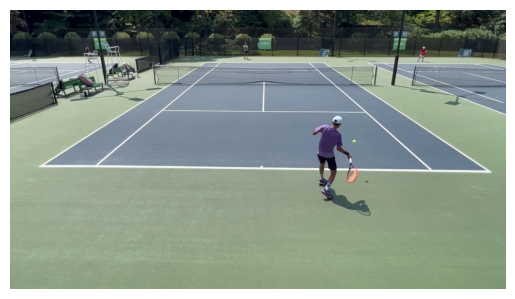

In [15]:
import matplotlib.pyplot as plt
frame = cv2.imread(img_path)
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

plt.imshow(frame)
plt.axis("off")
plt.show()

In [16]:
lm = extract_simplified_landmarks(frame)

if lm is None:
    lm = np.zeros(len(SELECT_LANDMARKS) * 4, dtype=np.float32)
    print("Brak landmarków – użyto zer")

# konwersacja do tensora jak w Dataset
x = torch.tensor(lm, dtype=torch.float32)

print("Typ:", type(x))
print("Kształt tensora:", x.shape)
print("Dtype:", x.dtype)
print("Min:", x.min().item())
print("Max:", x.max().item())
print("Pierwsze 20 wartości:\n", x[:20])


Typ: <class 'torch.Tensor'>
Kształt tensora: torch.Size([48])
Dtype: torch.float32
Min: -2.6354715824127197
Max: 3.779219388961792
Pierwsze 20 wartości:
 tensor([-0.2001, -2.6355,  0.0077,  0.9998,  0.6806, -2.1618, -0.0444,  0.9999,
        -0.7143, -2.3746,  0.0467,  0.8999,  0.7872, -0.7783, -0.0591,  0.9302,
        -0.5753, -2.5818,  0.0941,  0.3317])


/usr/local/lib/python3.12/dist-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


Architektura MLP

In [17]:
class PoseMLP(nn.Module):
    def __init__(self, input_dim=48, hid_dim=128, num_classes=4):
        super().__init__()

        self.fc1 = nn.Linear(input_dim, hid_dim)
        self.fc2 = nn.Linear(hid_dim, hid_dim)

        self.act = nn.GELU()
        self.norm = nn.LayerNorm(hid_dim)
        self.drop = nn.Dropout(0.3)

        self.classifier = nn.Linear(hid_dim, num_classes)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.norm(x)
        x = self.drop(x)

        x = self.fc2(x)
        x = self.act(x)

        return self.classifier(x)


Trening

In [18]:
model = PoseMLP(input_dim=48, hid_dim=128, num_classes=4).to(device)

In [19]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(),
                             lr=0.001)

In [20]:
epochs = 10

for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    model.train()
    total_loss = 0
    for x, y in train_loader:
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    train_loss = total_loss / len(train_loader)

    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for x, y in val_loader:
            x = x.to(device)
            y = y.to(device)

            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            val_loss += loss.item()

            # dokładność
            predicted = torch.argmax(y_pred, dim=1)
            correct += (predicted == y).sum().item()
            total += y.size(0)

    val_loss /= len(val_loader)
    val_acc = correct / total

    print(f"Train Loss: {train_loss:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")


Epoch 1/10


/usr/local/lib/python3.12/dist-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


Train Loss: 1.3089, Val Loss: 1.2009, Val Acc: 0.4258
Epoch 2/10
Train Loss: 1.1251, Val Loss: 1.0971, Val Acc: 0.5156
Epoch 3/10
Train Loss: 1.0676, Val Loss: 1.0195, Val Acc: 0.5312
Epoch 4/10
Train Loss: 0.9980, Val Loss: 0.9837, Val Acc: 0.5664
Epoch 5/10
Train Loss: 0.9621, Val Loss: 1.0008, Val Acc: 0.5586
Epoch 6/10
Train Loss: 0.9599, Val Loss: 0.9512, Val Acc: 0.5039
Epoch 7/10
Train Loss: 0.9224, Val Loss: 0.9659, Val Acc: 0.5586
Epoch 8/10
Train Loss: 0.9424, Val Loss: 0.9092, Val Acc: 0.5742
Epoch 9/10
Train Loss: 0.9058, Val Loss: 0.9158, Val Acc: 0.5898
Epoch 10/10
Train Loss: 0.9242, Val Loss: 0.9165, Val Acc: 0.5859
